In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv

from estuary.util import contrast_stretch, masked_contrast_stretch

# Load environment variables from .env file
load_dotenv("../.env")

True

In [6]:
from estuary.model.config import Bands, EstuaryConfig
from estuary.model.data import EstuaryDataset, create_splits

conf = EstuaryConfig(
    data=Path("/Volumes/x10pro/estuary/dataset/labels.csv"),
    region_splits=Path("/Volumes/x10pro/estuary/dataset/region_splits.csv"),
    bands=Bands.EIGHT,
    normalization_path=Path("/Volumes/x10pro/estuary/dataset/normalization/stats.json"),
    batch_size=1,
)

df_train, df_val, df_test = create_splits(conf)

ds = EstuaryDataset(df_train, conf, train=True)

ds[0].keys()

Some label classes will be ignored {'unsure'}


dict_keys(['image', 'label', 'source_tif'])

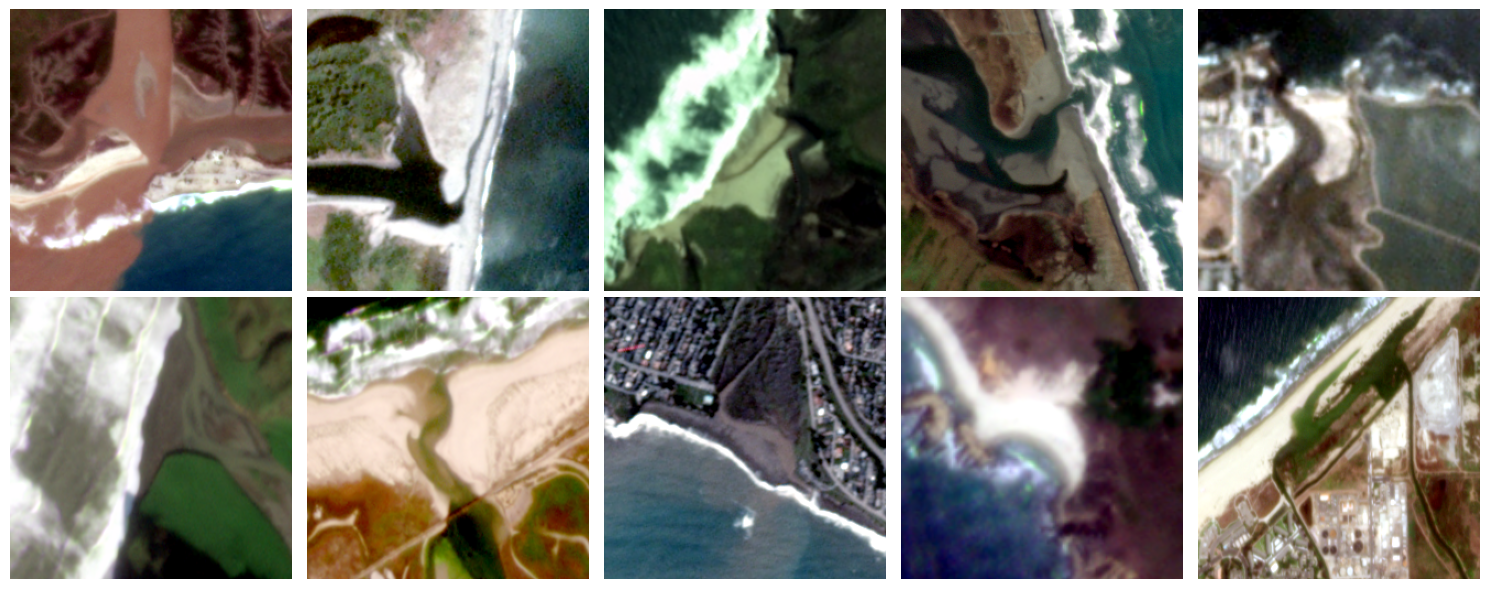

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
idxes = np.random.randint(0, len(ds), 10)
for ax, i in zip(axes.flatten(), idxes, strict=False):
    ax.axis("off")
    data = ds[i]["image"][0]
    data = ds.denormalize(data).detach().cpu().numpy()[0][[5, 3, 1]]
    nodata = (data == 0).all(axis=0)
    if not nodata.any():
        ax.imshow(contrast_stretch(data).transpose((1, 2, 0)))
    else:
        ax.imshow(masked_contrast_stretch(data, ~nodata).transpose((1, 2, 0)))

fig.tight_layout()
plt.show()

In [13]:
df = pd.read_csv("/Users/kyledorman/data/estuary/dataset/labels.csv").drop(columns="source_jpeg")
df.head()

,region,source_tif,label,acquired,instrument
0,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-09-03 18:37:27,dove
1,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-11-02 18:35:56,dove
2,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-07-10 18:21:59,dove
3,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-06-09 18:05:19,dove
4,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-01-01 18:06:34,dove


In [26]:
import shutil

new_df = []
for _, row in df.iterrows():
    a = Path(row.source_tif)
    pth = (
        Path("/Users/kyledorman/data/estuary/dataset/images/")
        / a.parents[1].name
        / a.parents[3].name
        / a.parents[2].name
        / a.name
    )
    pth.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy(a, pth)
    d = dict(row)
    d["source_tif"] = str(pth)
    new_df.append(d)

new_df = pd.DataFrame(new_df)

In [27]:
new_df.to_csv("/Users/kyledorman/data/estuary/dataset/labels.csv", index=False)